## Initial setup

In [ ]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
!nvidia-smi

Wed Nov 24 06:10:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [ ]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 30.51 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
# How many training images for SimCLR?
train_images = list(paths.list_images("imagenet-5-categories/train"))
print(len(train_images))

1250


In [ ]:
# Augmentation utilities (differs from the original implementation)
# Referred from: https://arxiv.org/pdf/2002.05709.pdf (Appendxi A 
# corresponding GitHub: https://github.com/google-research/simclr/)

class CustomAugment(object):
    def __call__(self, sample):        
        # Random flips
        sample = self._random_apply(tf.image.flip_left_right, sample, p=0.5)
        
        # Randomly apply transformation (color distortions) with probability p.
        sample = self._random_apply(self._color_jitter, sample, p=0.8)
        sample = self._random_apply(self._color_drop, sample, p=0.2)

        return sample

    def _color_jitter(self, x, s=1):
        # one can also shuffle the order of following augmentations
        # each time they are applied.
        x = tf.image.random_brightness(x, max_delta=0.8*s)
        x = tf.image.random_contrast(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_saturation(x, lower=1-0.8*s, upper=1+0.8*s)
        x = tf.image.random_hue(x, max_delta=0.2*s)
        x = tf.clip_by_value(x, 0, 1)
        return x
    
    def _color_drop(self, x):
        x = tf.image.rgb_to_grayscale(x)
        x = tf.tile(x, [1, 1, 1, 3])
        return x
    
    def _random_apply(self, func, x, p):
        return tf.cond(
          tf.less(tf.random.uniform([], minval=0, maxval=1, dtype=tf.float32),
                  tf.cast(p, tf.float32)),
          lambda: func(x),
          lambda: x)

In [ ]:
# Build the augmentation pipeline
data_augmentation = Sequential([Lambda(CustomAugment())])

In [ ]:
# Image preprocessing utils
@tf.function
def parse_images(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[224, 224])

    return image

In [ ]:
# Create TensorFlow dataset
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_ds = (
    train_ds
    .map(parse_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .shuffle(1024)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Utilities

In [ ]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainable = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [ ]:
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
!wget https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py

--2021-11-24 06:11:23--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]     891  --.-KB/s    in 0s      

2021-11-24 06:11:24 (42.0 MB/s) - ‘helpers.py’ saved [891/891]

--2021-11-24 06:11:24--  https://raw.githubusercontent.com/sthalles/SimCLR-tensorflow/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 891 [text/plain]
Saving to: ‘losse

In [ ]:
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers

In [ ]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

In [ ]:
@tf.function
def train_step(xis, xjs, model, optimizer, criterion, temperature):
    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)

        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))
        l_pos /= temperature

        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0

        for positives in [zis, zjs]:
            l_neg = sim_func_dim2(positives, negatives)

            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)

            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred=logits, y_true=labels)

        loss = loss / (2 * BATCH_SIZE)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

In [ ]:
wandb.init(project="simclr")

wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/at_sjsu/simclr/runs/265q00z9

In [ ]:
def train_simclr(model, dataset, optimizer, criterion,
                 temperature=0.1, epochs=100):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        for image_batch in dataset:
            a = data_augmentation(image_batch)
            b = data_augmentation(image_batch)

            loss = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))
        wandb.log({"nt_xentloss": np.mean(step_wise_loss)})
        
        if epoch % 10 == 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

## Training

In [ ]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

resnet_simclr_2 = get_resnet_simclr(256, 128, 50)

epoch_wise_loss, resnet_simclr  = train_simclr(resnet_simclr_2, train_ds, optimizer, criterion,
                 temperature=0.1, epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]wandb: Wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [00:31<1:44:32, 31.52s/it]

epoch: 1 loss: 4.765


  6%|▌         | 11/200 [02:48<43:06, 13.69s/it]

epoch: 11 loss: 4.020


 10%|█         | 21/200 [05:03<40:18, 13.51s/it]

epoch: 21 loss: 3.487


 16%|█▌        | 31/200 [07:19<38:19, 13.61s/it]

epoch: 31 loss: 3.033


 20%|██        | 41/200 [09:34<35:46, 13.50s/it]

epoch: 41 loss: 2.648


 26%|██▌       | 51/200 [11:49<33:33, 13.52s/it]

epoch: 51 loss: 2.378


 30%|███       | 61/200 [14:04<31:14, 13.49s/it]

epoch: 61 loss: 2.231


 36%|███▌      | 71/200 [16:19<29:03, 13.52s/it]

epoch: 71 loss: 2.082


 40%|████      | 81/200 [18:34<26:45, 13.49s/it]

epoch: 81 loss: 1.992


 46%|████▌     | 91/200 [20:49<24:32, 13.51s/it]

epoch: 91 loss: 1.922


 50%|█████     | 101/200 [23:04<22:15, 13.49s/it]

epoch: 101 loss: 1.848


 56%|█████▌    | 111/200 [25:19<20:01, 13.50s/it]

epoch: 111 loss: 1.796


 60%|██████    | 121/200 [27:34<17:46, 13.50s/it]

epoch: 121 loss: 1.744


 66%|██████▌   | 131/200 [29:49<15:31, 13.50s/it]

epoch: 131 loss: 1.703


 70%|███████   | 141/200 [32:04<13:15, 13.49s/it]

epoch: 141 loss: 1.671


 76%|███████▌  | 151/200 [34:26<11:05, 13.58s/it]

epoch: 151 loss: 1.637


 80%|████████  | 161/200 [36:41<08:46, 13.49s/it]

epoch: 161 loss: 1.614


 86%|████████▌ | 171/200 [38:56<06:31, 13.51s/it]

epoch: 171 loss: 1.599


 90%|█████████ | 181/200 [41:11<04:16, 13.51s/it]

epoch: 181 loss: 1.587


 96%|█████████▌| 191/200 [43:26<02:01, 13.50s/it]

epoch: 191 loss: 1.574


100%|██████████| 200/200 [45:27<00:00, 13.64s/it]


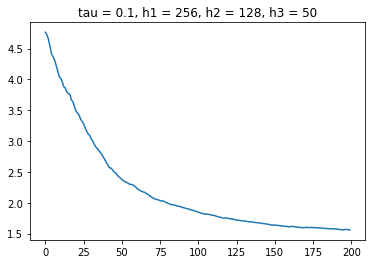

In [ ]:
plt.plot(epoch_wise_loss)
plt.title("tau = 0.1, h1 = 256, h2 = 128, h3 = 50")
plt.show()

In [ ]:
import datetime
filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet_simclr.h5"
filename

'20211124-073103resnet_simclr.h5'

In [ ]:
resnet_simclr.save_weights(filename)
wandb.save(filename)

[]